In [1]:
import xtrack as xt
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import apertls

In [2]:
path_lines = Path('/Users/gebruiker/sps_simulations/injection_lines')
line = xt.Line.from_json(Path(path_lines, 'sps_with_aperture_inj_q20.json'))
#line = xt.Line.from_json(Path(path_lines, 'injection_thin_approx_ap_with_deferred_expressions.json'))
#line = xt.Line.from_json(Path(path_lines, 'sps_lhc_q20_rf_with_ap.json'))
#Set cavitiy voltages correctly
line['acl.31735'].frequency = 800e6
line['acl.31735'].voltage = 2 * 0.18e6
line['acl.31735'].lag = 180

line['actcse.31632'].frequency = 200e6
line['actcse.31632'].voltage = 4.5e6
line['actcse.31632'].lag = 180

tw_ref = line.twiss4d()

for name in line.element_names:
    if line[name].__class__.__name__.startswith('Limit') or line[name].__class__.__name__.startswith('Multipole'):
        #Dogleg in LSS5 for extraction
        if 'qd.51710' in name:
            line[name].shift_y = -5.273e-3
        elif 'qfa.51810' in name:
            line[name].shift_y = -17.369e-3
        elif 'qd.51910' in name:
            line[name].shift_y = -5.273e-3
        #Dogleg in LSS1 for injection
        elif 'qd.11710' in name:
            line[name].shift_x = -4.80e-3
        elif 'qfa.11810' in name:
            line[name].shift_x = -2.97e-3
        elif 'qda.11910' in name:
            line[name].shift_x = -4.80e-3
    
    elif line[name].__class__.__name__.startswith('ThinSliceQuadrupole') or line[name].__class__.__name__.startswith('Quadrupole'):
        line['qd.51710'].shift_y = -5.273e-3
        line['qfa.51810'].shift_y = -17.369e-3
        line['qd.51910'].shift_y = -5.273e-3
        line['qd.11710'].shift_x = -4.80e-3 #Hannes Thesis says qda.
        line['qf.11810'].shift_x = -2.97e-3 #Hannes Thesis says qfa.
        line['qda.11910'].shift_x = -4.80e-3

tw_before = line.twiss4d()
tw = line.twiss()

Loading line from dict:   0%|          | 0/17781 [00:00<?, ?it/s]

Done loading line from dict.           


<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
<>:12: SyntaxWarning: invalid escape sequence '\.'
/var/folders/q4/rcyb5f2524q8p03j88z0mxj80000gn/T/ipykernel_62446/2267181951.py:8: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/q4/rcyb5f2524q8p03j88z0mxj80000gn/T/ipykernel_62446/2267181951.py:8: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/q4/rcyb5f2524q8p03j88z0mxj80000gn/T/ipykernel_62446/2267181951.py:12: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/q4/rcyb5f2524q8p03j88z0mxj80000gn/T/ipy

Iteration 0, x_rms: 3.97e-03 -> 1.21e-04, y_rms: 1.54e-03 -> 2.85e-04
Iteration 1, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.85e-04 -> 2.81e-04
Iteration 2, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.81e-04 -> 2.79e-04
Iteration 3, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.79e-04 -> 2.78e-04
Iteration 4, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.78e-04 -> 2.77e-04
Iteration 5, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 6, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 7, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 8, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04
Iteration 9, x_rms: 1.21e-04 -> 1.21e-04, y_rms: 2.77e-04 -> 2.77e-04


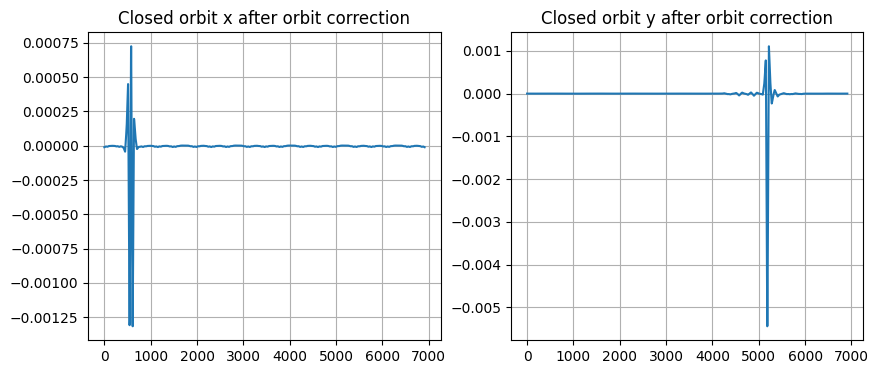

In [3]:
tt = line.get_table()

#Orbit correction
tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
line.steering_monitors_x = tt_monitors.name
line.steering_monitors_y = tt_monitors.name

tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=5, n_iter=10)

#Plot orbits to verify
tw = line.twiss()
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(tw.s, tw.x)
ax[0].set_title('Closed orbit x after orbit correction')
ax[0].grid()
ax[1].plot(tw.s, tw.y)
ax[1].set_title('Closed orbit y after orbit correction')
ax[1].grid()

In [4]:
def insert_elements_in_line(line, insert_names, insert_elements):
    # Update insert_names to handle variable-length keys
    
    insert_names = {kk: vv for dct in insert_names for kk, vv in dct.items()}
    idxs = list(insert_names.values())
    names = list(insert_names.keys())
    max_length = max(max(map(len, line.element_names)), max(map(len, names)))
    element_names = np.array(line.element_names, dtype=f'<U{max_length}')
    names = np.array(names, dtype=f'<U{max_length}')
    element_names = np.insert(element_names, idxs, names)


    insert_elements = {kk: vv for dct in insert_elements for kk, vv in dct.items()}

    # Update line's element names and element dictionary
    line.element_names = element_names.tolist()
    line.element_dict = {**line.element_dict, **insert_elements}

In [5]:
def circle(radius, x_0, y_0, t):
    x = x_0 + radius*np.cos(t)
    y = y_0 + radius*np.sin(t)

    return x, y

def circle_vertical_coord(radius, x_0, y_0, x):
    t = np.acos((x-x_0)/radius)
    y = y_0 + radius*np.sin(t)

    return y
    
def straight_line(alpha, x_0, y_0, x):
    return alpha*(x-x_0) + y_0

def get_sagitta_effect_on_aperture(s, length, bending_radius, offset_middle_dipole):
    #center of the bending circle
    s0 = length/2
    x0 = -(bending_radius-offset_middle_dipole)

    #getting x position for that circle
    x = circle_vertical_coord(bending_radius, s0, x0, s)

    return x

In [6]:
#Apertures for each dipole type
aper_mbb = line['vebb.10070.b_aper'].copy()
aper_mba = line['veba.10030.b_aper'].copy()

#Defining bending radius
R_mba = 1/line['mba.10030'].k0
R_mbb = 1/line['mbb.10070'].k0
assert R_mba == R_mbb
bending_radius = 1/line['mba.10030'].k0

#Defining magnetic length which is considered as the length of the magnet
assert line['mba.10030'].length == line['mbb.10070'].length
length = line['mba.10030'].length

#Sagitta offsets (predefined)
offset_end_dipole=4.4e-3
offset_middle_dipole=2.2e-3

In [86]:
env = xt.Environment()
line_test_mbb = env.new_line(components=[
    env.new('aper_upstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y),
    env.new('bend_test', xt.RBend, length = line['mbb.10070'].length, k0=line['mbb.10070'].k0),
    env.new('aper_downstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y)])
line_test_mbb.particle_ref = line.particle_ref.copy()
tt_ap = line_test_mbb.get_aperture_table()

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/gebruiker/miniforge3/envs/xsuite2/lib' ignored
ld: warning: duplicate -rpath '/Users/gebruiker/miniforge3/envs/xsuite2/lib' ignored


Done compiling ContextCpu kernels.


In [ ]:
line.particle_ref

NameError: name 'line' is not defined

In [63]:
nb_slices = 11
s_start = line_test_mbb.get_s_position('bend_test')
s_stop = s_start + line_test_mbb['bend_test'].length
s_positions = np.linspace(s_start, s_stop, nb_slices)

x_orbits = get_sagitta_effect_on_aperture(s_positions, length, bending_radius, offset_middle_dipole)


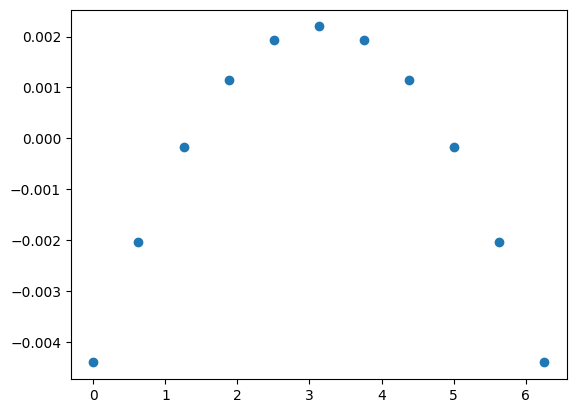

In [64]:
plt.figure()
plt.scatter(s_positions, x_orbits)

In [7]:
def get_apertls_aper_elem(element, name):
    if isinstance(element, xt.LimitEllipse):
        return apertls.EllipseAperture(element, name)
    elif isinstance(element, xt.LimitRect):
        return apertls.RectAperture(element, name)
    elif isinstance(element, xt.LimitRectEllipse):
        return apertls.RectEllipseAperture(element, name)
    elif isinstance(element, xt.LimitRacetrack):
        return apertls.RacetrackAperture(element, name)
    
    else:
        ValueError('Aperture element is not a known apertls element')

def make_sagitta_dipole_apertures(x_orbits, aper_element):
    aperture_slices = []

    for x_pos in x_orbits:
        aper_pos = aper_element.copy()
        aper_pos.shift_x = -x_pos
        aperture_slices.append(aper_pos)
    
    return np.array(aperture_slices)

def generate_slices_names(name_element, nb_slices):
    slices_names = []

    for i in range(nb_slices):
        slices_names.append(f'{name_element}..{i}_aper')
    
    return slices_names

In [8]:
env = xt.Environment()
line_test_mbb = env.new_line(components=[
    env.new('aper_upstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y),
    env.new('bend_test', xt.RBend, length = line['mbb.10070'].length, k0=line['mbb.10070'].k0),
    env.new('aper_downstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y)])
line_test_mbb.particle_ref = line.particle_ref.copy()

nb_slices = 11
s_start = line_test_mbb.get_s_position('bend_test')
s_stop = s_start + line_test_mbb['bend_test'].length
s_positions = np.linspace(s_start, s_stop, nb_slices)

x_orbits = get_sagitta_effect_on_aperture(s_positions, length, bending_radius, offset_middle_dipole)
aper_slices = make_sagitta_dipole_apertures(x_orbits, aper_mbb)
slices_names = generate_slices_names('mbb.10070', nb_slices)

insertions = []
env = line_test_mbb.env
for nn, ee, ss in zip(slices_names, aper_slices, s_positions):
    env.elements[nn] = ee
    insertions.append(env.place(nn, at=ss))
line_test_mbb.insert(insertions)

Slicing line:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
line_test_mbb.get_table()

Table: 28 rows, 11 cols
name                             s element_type        isthick isreplica parent_name iscollective ...
aper_upstream                    0 LimitRect             False     False None               False
bend_test_entry                  0 Marker                False     False None               False
bend_test..entry_map             0 ThinSliceRBendEntry   False     False bend_test          False
mbb.10070..0_aper                0 LimitRect             False     False None               False
bend_test..0                     0 ThickSliceRBend        True     False bend_test          False
mbb.10070..1_aper         0.626002 LimitRect             False     False None               False
bend_test..1              0.626002 ThickSliceRBend        True     False bend_test          False
mbb.10070..2_aper            1.252 LimitRect             False     False None               False
bend_test..2                 1.252 ThickSliceRBend        True     False bend_test        

In [144]:
env = xt.Environment()
line_test_mbb = env.new_line(components=[
    env.new('aper_upstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y),
    env.new('bend_test', xt.RBend, length = line['mbb.10070'].length, k0=line['mbb.10070'].k0),
    env.new('aper_downstream', aper_mbb.__class__, min_x = aper_mbb.min_x, max_x = aper_mbb.max_x, min_y = aper_mbb.min_y, max_y = aper_mbb.max_y)])
line_test_mbb.particle_ref = line.particle_ref.copy()

nb_slices = 11
s_start = line_test_mbb.get_s_position('bend_test')
s_stop = s_start + line_test_mbb['bend_test'].length
s_positions = np.linspace(s_start, s_stop, nb_slices)

x_orbits = get_sagitta_effect_on_aperture(s_positions, length, bending_radius, offset_middle_dipole)
aper_slices = make_sagitta_dipole_apertures(x_orbits, aper_mbb)
slices_names = generate_slices_names(line_test_mbb.element_names[1], nb_slices)

slicing_dico = line_test_mbb.slice_thick_elements(slicing_strategies=[xt.Strategy(slicing=xt.Teapot(nb_slices-1, mode='thick'))])

bend_slices = {name : line_test_mbb.element_names.index(name) for name in slicing_dico['bend_test'] if line_test_mbb[name].__class__.__name__ == 'ThickSliceRBend'}


insert_names = [
    {f'{name}_aper' : bend_slices[name] for name in bend_slices }
]
insert_names.append({f'bend_test..{nb_slices-1}_aper' : bend_slices[f'bend_test..{nb_slices-2}'] + 1})

insert_elements = [
    {f'{name}_aper' : aper_slices[i].copy() for i, name in enumerate(bend_slices)}
]

insert_elements.append({f'bend_test..{nb_slices-1}_aper' : aper_slices[-1]})

insert_elements_in_line(line_test_mbb, insert_names, insert_elements)
# line_test_mbb.cut_at_s(s_positions[:-1])
# for i in range(len(slices_names)):
#     line_test_mbb.insert(slices_names[i], aper_slices[i], at=s_positions[i])

Slicing line:   0%|          | 0/3 [00:00<?, ?it/s]

In [148]:
tt = line.get_table()

In [159]:
tt.rows['.*.10070.*']

Table: 3 rows, 11 cols
name                          s element_type isthick isreplica parent_name iscollective ...
vebb.10070.a_aper       16.5716 LimitRect      False     False None               False
mbb.10070                16.755 RBend           True     False None               False
vebb.10070.b_aper       23.2104 LimitRect      False     False None               False

In [161]:
mba_first_elem = 'mba.10030'
mba_first_elem.split('.')[1]

'10030'

In [ ]:
class TrigonometryEquations:
    def circle(radius, x_0, y_0, t):
        x = x_0 + radius*np.cos(t)
        y = y_0 + radius*np.sin(t)

        return x, y

    def circle_vertical_coord(radius, x_0, y_0, x):
        t = np.acos((x-x_0)/radius)
        y = y_0 + radius*np.sin(t)

        return y
        
    def straight_line(alpha, x_0, y_0, x):
        return alpha*(x-x_0) + y_0


class SagittaSlicer:
    def __init__(self, line, nb_slices, offset_middle_dipole=2.2e-3, sequence = 'SPS'):
        self.line = line
        self.nb_slices = nb_slices
        self.offset_middle_dipole = offset_middle_dipole

        self.tt_thick = self.line.get_table()
        self.sequence = sequence

        assert self.sequence == 'SPS' or self.sequence == 'other', 'Sequence type not supported !'

        self.length, self.bending_radius = self.get_dipole_info()
        
    
    def pipe_check(self):
        pass

    def get_dipole_info(self):
        #All dipoles need to have the same magnetic length and k0, otherwise it is not supported 
        if self.sequence == 'SPS':
            mba_first_elem = self.tt_thick.rows['mba.*'].name[0]
            mbb_first_elem = self.tt_thick.rows['mbb.*'].name[0]

            assert mba_first_elem.length == mbb_first_elem.length, 'MBA and MBB do not have the same magnetic length as they should'
            assert mba_first_elem.k0 == mbb_first_elem.k0, 'MBA and MBB do not have the same bending radius as they should'

            return mba_first_elem.length, 1/mba_first_elem.k0

        else:
            AssertionError('Not supported')


    # def get_sagitta_effect_on_aperture(s, length, bending_radius, offset_middle_dipole):
    # #center of the bending circle
    #     s0 = length/2
    #     x0 = -(bending_radius-offset_middle_dipole)

    #     #getting x position for that circle
    #     x = circle_vertical_coord(bending_radius, s0, x0, s)

    #     return x

    def get_pipe_aperture_dipoles(self):
        assert self.sequence == 'SPS', 'Function only implemented for SPS'

        mba_first_elem = self.tt_thick.rows['mba.*'].name[0]
        mbb_first_elem = self.tt_thick.rows['mbb.*'].name[0]

        nb_mba_first_elem = mba_first_elem.split('.')[1]
        nb_mbb_first_elem = mbb_first_elem.split('.')[1]

        aper_mba = self.line[f'veba.{nb_mba_first_elem}.aper_b'].copy()
        aper_mbb = self.line[f'vebb.{nb_mbb_first_elem}.aper_b'].copy()

        return aper_mba, aper_mbb
    


    def get_sagitta_effect_on_aperture(self, s):
        #center of the bending circle
        s0 = self.length/2
        x0 = -(self.bending_radius-self.offset_middle_dipole)

        #getting x position for that circle
        x = circle_vertical_coord(self.bending_radius, s0, x0, s)

        return x
    

    def make_sagitta_dipole_apertures(x_orbits, aper_element):
        aperture_slices = []

        for x_pos in x_orbits:
            aper_pos = aper_element.copy()
            aper_pos.shift_x = -x_pos
            aperture_slices.append(aper_pos)
        
        return np.array(aperture_slices)
    
    def install_sagitta_sps(self):
        aper_mba, aper_mbb = self.get_pipe_aperture_dipoles()

        slicing_dico = self.line.slice_thick_elements(slicing_strategies=[xt.Strategy(slicing=xt.Teapot(self.nb_slices-1, mode='thick'))])
        
        for dipole_type in ['mba', 'mbb']:
            unsliced_names = self.tt_thick.rows[f'{dipole_type}.*'].name

            x_orbits = get_sagitta_effect_on_aperture(s_positions, length, bending_radius, offset_middle_dipole)
            aper_slices = make_sagitta_dipole_apertures(x_orbits, aper_mbb)
            for name_dipole in unsliced_names:
                bend_slices = {name : self.line.element_names.index(name) for name in slicing_dico[name_dipole] if self.line[name].__class__.__name__ == 'ThickSliceRBend'}

                insert_names = [
                    {f'{name}_aper' : bend_slices[name] for name in bend_slices }
                ]
                insert_names.append({f'bend_test..{nb_slices-1}_aper' : bend_slices[f'bend_test..{nb_slices-2}'] + 1})

                insert_elements = [
                    {f'{name}_aper' : aper_slices[i].copy() for i, name in enumerate(bend_slices)}
                ]

                insert_elements.append({f'bend_test..{nb_slices-1}_aper' : aper_slices[-1]})

                insert_elements_in_line(line_test_mbb, insert_names, insert_elements)
                